In [1]:
!pip install ggplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.6 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import csv
import requests
import codecs
import re
import os
import json
import sys
from datetime import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
vendas_2019 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cap 01_ASSETS_PBL_FIAP_ON_1TSC_FASE_5/vendas_linha_petshop_2019.csv', encoding="ISO-8859-1", sep = ';')

vendas_2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cap 01_ASSETS_PBL_FIAP_ON_1TSC_FASE_5/vendas_linha_petshop_2020.csv', encoding="ISO-8859-1", sep = ';')

vendas_2021 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cap 01_ASSETS_PBL_FIAP_ON_1TSC_FASE_5/vendas_linha_petshop_2021.csv', encoding="ISO-8859-1", sep = ';')

vendas_2022 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cap 01_ASSETS_PBL_FIAP_ON_1TSC_FASE_5/vendas_linha_petshop_2022.csv', encoding="ISO-8859-1", sep = ';')

df_vendas = pd.DataFrame()

df_vendas = pd.concat([df_vendas, vendas_2019, vendas_2020, vendas_2021, vendas_2022], ignore_index=True)

# 2) Analise os dados na perspectiva da coluna quantidade. Existem outliers nos dados disponibilizados? É possível identificar algo em relação às vendas associadas a estes outliers? Justifique sua resposta. Calcule uma estimativa de variabilidade que ignore o efeito desses outliers.

In [3]:
df_quantidade = df_vendas[['quantidade']]
df_quantidade = df_quantidade.dropna(subset = ['quantidade']).reset_index(drop=True)
df_quantidade = df_quantidade[df_quantidade['quantidade'] != ' '].astype(float)

In [4]:
print('Média: ', np.mean(df_quantidade['quantidade']))
print('Desvio Padrão: ', np.std(df_quantidade['quantidade']))
print('Coenficiente de variação: ',  np.std(df_quantidade['quantidade'])/np.mean(df_quantidade['quantidade']))

Média:  3.650637870467072
Desvio Padrão:  12.045026745182026
Coenficiente de variação:  3.2994307221277346


In [5]:
# Calcular os quartis Q1 e Q3
Q1 = df_quantidade['quantidade'].quantile(0.25)
Q3 = df_quantidade['quantidade'].quantile(0.75)

# Calcular o IQR
IQR = Q3 - Q1

# Definir os limites inferior e superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Remover outliers
outliers = df_quantidade[(df_quantidade['quantidade'] >= limite_inferior) & (df_quantidade['quantidade'] <= limite_superior)]

print(outliers)

        quantidade
0              2.0
1              2.0
3              2.0
5              3.0
6              2.0
...            ...
200261         3.0
200262         1.0
200263         3.0
200264         2.0
200265         1.0

[188836 rows x 1 columns]


In [6]:
print('% de outliers na amostra total: ', 100 - ((outliers['quantidade'].count() / df_quantidade['quantidade'].count()) * 100))

% de outliers na amostra total:  5.638145303544391


In [36]:
df_quantidade_categoria = df_vendas[['categoriaprod', 'regiao_pais', 'quantidade']]
df_quantidade_categoria = df_quantidade_categoria.dropna(subset = ['quantidade']).reset_index(drop=True)
df_quantidade_categoria = df_quantidade_categoria[df_quantidade_categoria['quantidade'] != ' ']
df_quantidade_categoria['quantidade'] = df_quantidade_categoria[['quantidade']].astype(float)

<ipython-input-36-a09d04df9e67>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_quantidade_categoria['quantidade'] = df_quantidade_categoria[['quantidade']].astype(float)


In [18]:
df_quantidade_categoria_outliers =  pd.DataFrame({'outliers': outliers['quantidade'].unique()})

In [22]:
df_quantidade_categoria_outliers

,outliers
0,2.0
1,3.0
2,1.0
3,0.0


In [37]:
df_quantidade_categoria = df_quantidade_categoria[~df_quantidade_categoria['quantidade'].isin([0.0, 1.0, 2.0, 3.0])]

In [41]:
df_quantidade_categoria.groupby(['categoriaprod', 'regiao_pais']).count().reset_index(drop=False).sort_values('quantidade', ascending=False).head()

,categoriaprod,regiao_pais,quantidade
7,Alimentação,Norte,1257
8,Alimentação,Sudeste,1206
5,Alimentação,Centro Oeste,813
6,Alimentação,Nordeste,598
2,Acessório,Norte,519


# 3) Em relação à média de preço, há diferença estatisticamente significativa entre a média de preço de alguma região e a média da população? E em relação à média de preço de alguma modalidade de pagamento e à média da população? Justifique a hipótese.

In [64]:
df_quantiade_valor_total_bruto = df_vendas[['regiao_pais', 'formapagto', 'valor','valor_total_bruto']]
df_quantiade_valor_total_bruto = df_quantiade_valor_total_bruto.dropna(subset = ['valor_total_bruto']).reset_index(drop=True)
df_quantiade_valor_total_bruto = df_quantiade_valor_total_bruto[df_quantiade_valor_total_bruto['valor'] != ' '].replace(',','.',regex=True)
df_quantiade_valor_total_bruto = df_quantiade_valor_total_bruto[df_quantiade_valor_total_bruto['valor_total_bruto'] != ' '].replace(',','.',regex=True)
df_quantiade_valor_total_bruto['valor'] = df_quantiade_valor_total_bruto[['valor']].astype(float)
df_quantiade_valor_total_bruto['valor_total_bruto'] = df_quantiade_valor_total_bruto[['valor_total_bruto']].astype(float)

In [65]:
toda_amostra = np.array(df_quantiade_valor_total_bruto['valor_total_bruto'])

# Hipótese nula: a média do valor bruto de pedidos da região sul é igual a média da população.
mu_hipotese = df_quantiade_valor_total_bruto[df_quantiade_valor_total_bruto['regiao_pais'] == 'Sul']['valor_total_bruto'].mean()

# Calcula a estatística t e o p-valor
t_statistic, p_value = stats.ttest_1samp(toda_amostra, mu_hipotese)

# Valor crítico para alpha = 0.05 (bicaudal)
alpha = 0.05
graus_liberdade = len(toda_amostra) - 1
valor_critico = stats.t.ppf(1 - alpha / 2, graus_liberdade)

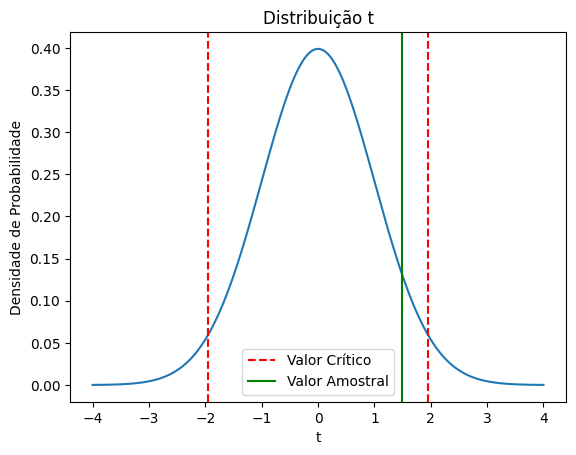

Estatística t: 1.49
Valor-p: 0.135
Valor crítico: ±1.96
Não rejeitamos a hipótese nula.


In [66]:
# Cria o gráfico da distribuição t
x = np.linspace(-4, 4, 200)
y = stats.t.pdf(x, graus_liberdade)

plt.plot(x, y)
plt.axvline(valor_critico, color='red', linestyle='--', label='Valor Crítico')
plt.axvline(-valor_critico, color='red', linestyle='--')
plt.axvline(t_statistic, color='green', linestyle='-', label='Valor Amostral')
plt.title('Distribuição t')
plt.xlabel('t')
plt.ylabel('Densidade de Probabilidade')
plt.legend()
plt.show()

# Imprime os resultados
print(f"Estatística t: {t_statistic:.2f}")
print(f"Valor-p: {p_value:.3f}")
print(f"Valor crítico: ±{valor_critico:.2f}")

# Conclusão
if abs(t_statistic) > valor_critico:
  print("Rejeitamos a hipótese nula.")
else:
  print("Não rejeitamos a hipótese nula.")

In [78]:
toda_amostra = np.array(df_quantiade_valor_total_bruto['valor_total_bruto'])

# Hipótese nula: a média do valor bruto de pedidos da forma de pagamento Boleto Bancário é igual a média da população.
mu_hipotese = df_quantiade_valor_total_bruto[df_quantiade_valor_total_bruto['formapagto'] == 'Boleto Bancário']['valor_total_bruto'].mean()

# Calcula a estatística t e o p-valor
t_statistic, p_value = stats.ttest_1samp(toda_amostra, mu_hipotese)

# Valor crítico para alpha = 0.05 (bicaudal)
alpha = 0.05
graus_liberdade = len(toda_amostra) - 1
valor_critico = stats.t.ppf(1 - alpha / 2, graus_liberdade)

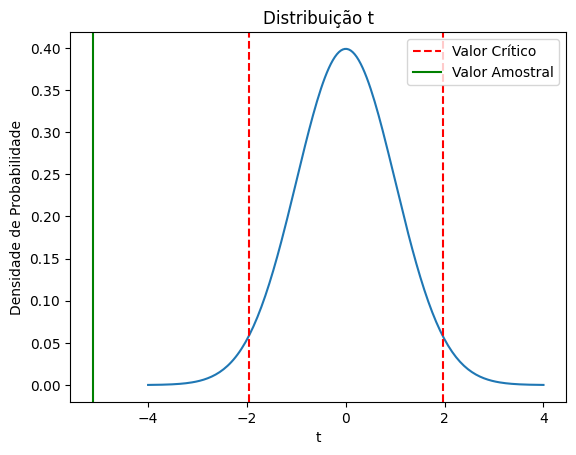

Estatística t: -5.12
Valor-p: 0.000
Valor crítico: ±1.96
Rejeitamos a hipótese nula.


In [79]:
# Cria o gráfico da distribuição t
x = np.linspace(-4, 4, 200)
y = stats.t.pdf(x, graus_liberdade)

plt.plot(x, y)
plt.axvline(valor_critico, color='red', linestyle='--', label='Valor Crítico')
plt.axvline(-valor_critico, color='red', linestyle='--')
plt.axvline(t_statistic, color='green', linestyle='-', label='Valor Amostral')
plt.title('Distribuição t')
plt.xlabel('t')
plt.ylabel('Densidade de Probabilidade')
plt.legend()
plt.show()

# Imprime os resultados
print(f"Estatística t: {t_statistic:.2f}")
print(f"Valor-p: {p_value:.3f}")
print(f"Valor crítico: ±{valor_critico:.2f}")

# Conclusão
if abs(t_statistic) > valor_critico:
  print("Rejeitamos a hipótese nula.")
else:
  print("Não rejeitamos a hipótese nula.")

# Calcule a matriz de correlação dos dados fornecidos. Quais as variáveis que apresentam forte correlação positiva ou negativa? Acrescente a matriz de correlação como uma imagem e anexe-a ao seu relatório.

In [ ]:
df_vendas = df_vendas[df_vendas['valor'] != ' '].replace(',','.',regex=True)
df_vendas['valor'] = df_vendas[['valor']].astype(float)
df_vendas = df_vendas[df_vendas['quantidade'] != ' '].replace(',','.',regex=True)
df_vendas['quantidade'] = df_vendas[['quantidade']].astype(float)
df_vendas = df_vendas[df_vendas['valor_total_bruto'] != ' '].replace(',','.',regex=True)
df_vendas['valor_total_bruto'] = df_vendas[['valor_total_bruto']].astype(float)
df_vendas = df_vendas[df_vendas['valor_comissao'] != ' '].replace(',','.',regex=True)
df_vendas['valor_comissao'] = df_vendas[['valor_comissao']].astype(float)
df_vendas = df_vendas[df_vendas['lucro_liquido'] != ' '].replace(',','.',regex=True)
df_vendas['lucro_liquido'] = df_vendas[['lucro_liquido']].astype(float)

In [ ]:
df_vendas[['valor', 'quantidade', 'valor_total_bruto', 'valor_comissao', 'lucro_liquido']].corr()

,valor,quantidade,valor_total_bruto,valor_comissao,lucro_liquido
valor,1.000000,-0.011868,0.061937,0.213190,0.191437
quantidade,-0.011868,1.000000,0.120868,0.322192,0.559976
valor_total_bruto,0.061937,0.120868,1.000000,0.264347,0.262412
valor_comissao,0.213190,0.322192,0.264347,1.000000,0.888695
lucro_liquido,0.191437,0.559976,0.262412,0.888695,1.000000
